# Centro de Investigación en Matemáticas
# Inteligencia Artificial
## Tarea 6. Redes recurrentes
### José Miguel Saavedra Aguilar

Importamos los paquetes que utilizaremos

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, TimeDistributed, Bidirectional, LSTM
from tensorflow.keras.utils import to_categorical


Cargamos los datos de entrenamiento y prueba descargados previamente de Kaggle

In [ ]:
# Load the training dataset with headers
train_data = pd.read_csv('/tarea/train.csv', header=0)

# Load the testing dataset with headers
test_data = pd.read_csv('/tarea/test.csv', header=0)

# The second to last column is the subject identifier and the last column is the label to be predicted
subject_column = -2
label_column = -1

Agrupamos los datos por sujeto

In [ ]:
# Group by subject to create sequences
def group_by_subject(data):
    grouped_data = []
    grouped_labels = []
    subjects = data.iloc[:, subject_column].unique()

    for subject in subjects:
        subject_data = data[data.iloc[:, subject_column] == subject]
        features = subject_data.iloc[:, :-2].values  # All columns except the last two
        labels = subject_data.iloc[:, label_column].values  # Labels for each timestep
        grouped_data.append(features)
        grouped_labels.append(labels)

    return grouped_data, grouped_labels

X_train, y_train = group_by_subject(train_data)
X_test, y_test = group_by_subject(test_data)

# Determine the maximum sequence length
maxlen = max(max(len(seq) for seq in X_train), max(len(seq) for seq in X_test))

Debemos hacer un padding a la secuencia para que todas tengan el mismo tamaño. Cada una se completa con los datos de la última acción que estaba siendo realizada.

In [ ]:
# Function to pad sequences by repeating the last timestep
def pad_sequences_repeating_last(sequences, maxlen):
    padded_sequences = []
    for seq in sequences:
        pad_len = maxlen - len(seq)
        if pad_len > 0:
            if seq.ndim == 1:
                # For 1D sequences (labels)
                padding = np.repeat(seq[-1], pad_len)
            else:
                # For 2D sequences (features)
                padding = np.tile(seq[-1:], (pad_len, 1))
            padded_seq = np.concatenate((seq, padding), axis=0)
        else:
            padded_seq = seq
        padded_sequences.append(padded_seq)
    return np.array(padded_sequences)

# Pad the data sequences
X_train = pad_sequences_repeating_last(X_train, maxlen)
X_test = pad_sequences_repeating_last(X_test, maxlen)

# Pad the labels sequences
y_train = pad_sequences_repeating_last(y_train, maxlen)
y_test = pad_sequences_repeating_last(y_test, maxlen)

# Encode the categorical target variable
label_encoder = LabelEncoder()

# Encode training labels
y_train_encoded = [label_encoder.fit_transform(seq) for seq in y_train]
y_train_categorical = np.array([to_categorical(seq) for seq in y_train_encoded])

# Encode testing labels
y_test_encoded = [label_encoder.transform(seq) for seq in y_test]
y_test_categorical = np.array([to_categorical(seq) for seq in y_test_encoded])

# Get the number of timesteps and features after padding
timesteps, features = X_train.shape[1], X_train.shape[2]
n_classes = y_train_categorical.shape[2]


Definimos el modelo con una RNN simple bidireccional para toda la secuencia, seguida por dos capas densas utilizando TimeDistributed para que la misma capa se aplique a cada tiempo.

In [ ]:
# Define the RNN model
model = Sequential()
model.add(Bidirectional(SimpleRNN(50, return_sequences=True, input_shape=(timesteps, features), activation='LeakyReLU')))
model.add(TimeDistributed(Dense(100, activation='LeakyReLU')))
model.add(TimeDistributed(Dense(n_classes, activation='sigmoid')))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Entrenamos el modelo

In [ ]:
# Train the model
history = model.fit(X_train, y_train_categorical, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
1/1 [==============================] - 7s 7s/step - loss: 1.8215 - accuracy: 0.2722 - val_loss: 1.6276 - val_accuracy: 0.3462
Epoch 2/100
1/1 [==============================] - 2s 2s/step - loss: 1.6157 - accuracy: 0.3744 - val_loss: 1.5434 - val_accuracy: 0.4430
Epoch 3/100
1/1 [==============================] - 1s 1s/step - loss: 1.5308 - accuracy: 0.4574 - val_loss: 1.4116 - val_accuracy: 0.5134
Epoch 4/100
1/1 [==============================] - 1s 1s/step - loss: 1.4111 - accuracy: 0.4898 - val_loss: 1.3104 - val_accuracy: 0.4054
Epoch 5/100
1/1 [==============================] - 1s 1s/step - loss: 1.3207 - accuracy: 0.3742 - val_loss: 1.2066 - val_accuracy: 0.4098
Epoch 6/100
1/1 [==============================] - 1s 1s/step - loss: 1.2099 - accuracy: 0.4534 - val_loss: 1.1216 - val_accuracy: 0.4205
Epoch 7/100
1/1 [==============================] - 1s 1s/step - loss: 1.1251 - accuracy: 0.4612 - val_loss: 1.0695 - val_accuracy: 0.3907
Epoch 8/100
1/1 [=================

Una vez entrenado el modelo, veamos que tan bien predice los datos de prueba

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test_categorical)
print(f'Test Accuracy: {test_accuracy:.4f}')

1/1 [==============================] - 0s 196ms/step - loss: 0.1060 - accuracy: 0.9593
Test Accuracy: 0.9593


Predecimos las etiquetas

In [ ]:
predictions = model.predict(X_test)

# Predicted labels for each timestep
predicted_labels = np.argmax(predictions, axis=-1)

1/1 [==============================] - 0s 415ms/step


In [ ]:
predicted_labels

array([[2, 2, 2, ..., 5, 5, 5],
       [2, 2, 2, ..., 5, 5, 5],
       [2, 2, 2, ..., 4, 4, 4],
       ...,
       [2, 2, 2, ..., 5, 5, 5],
       [2, 2, 2, ..., 5, 5, 5],
       [2, 2, 2, ..., 5, 5, 5]])

Finalmente, presentamos la gráfica de secuencias de los sujetos de prueba y las predicciones.

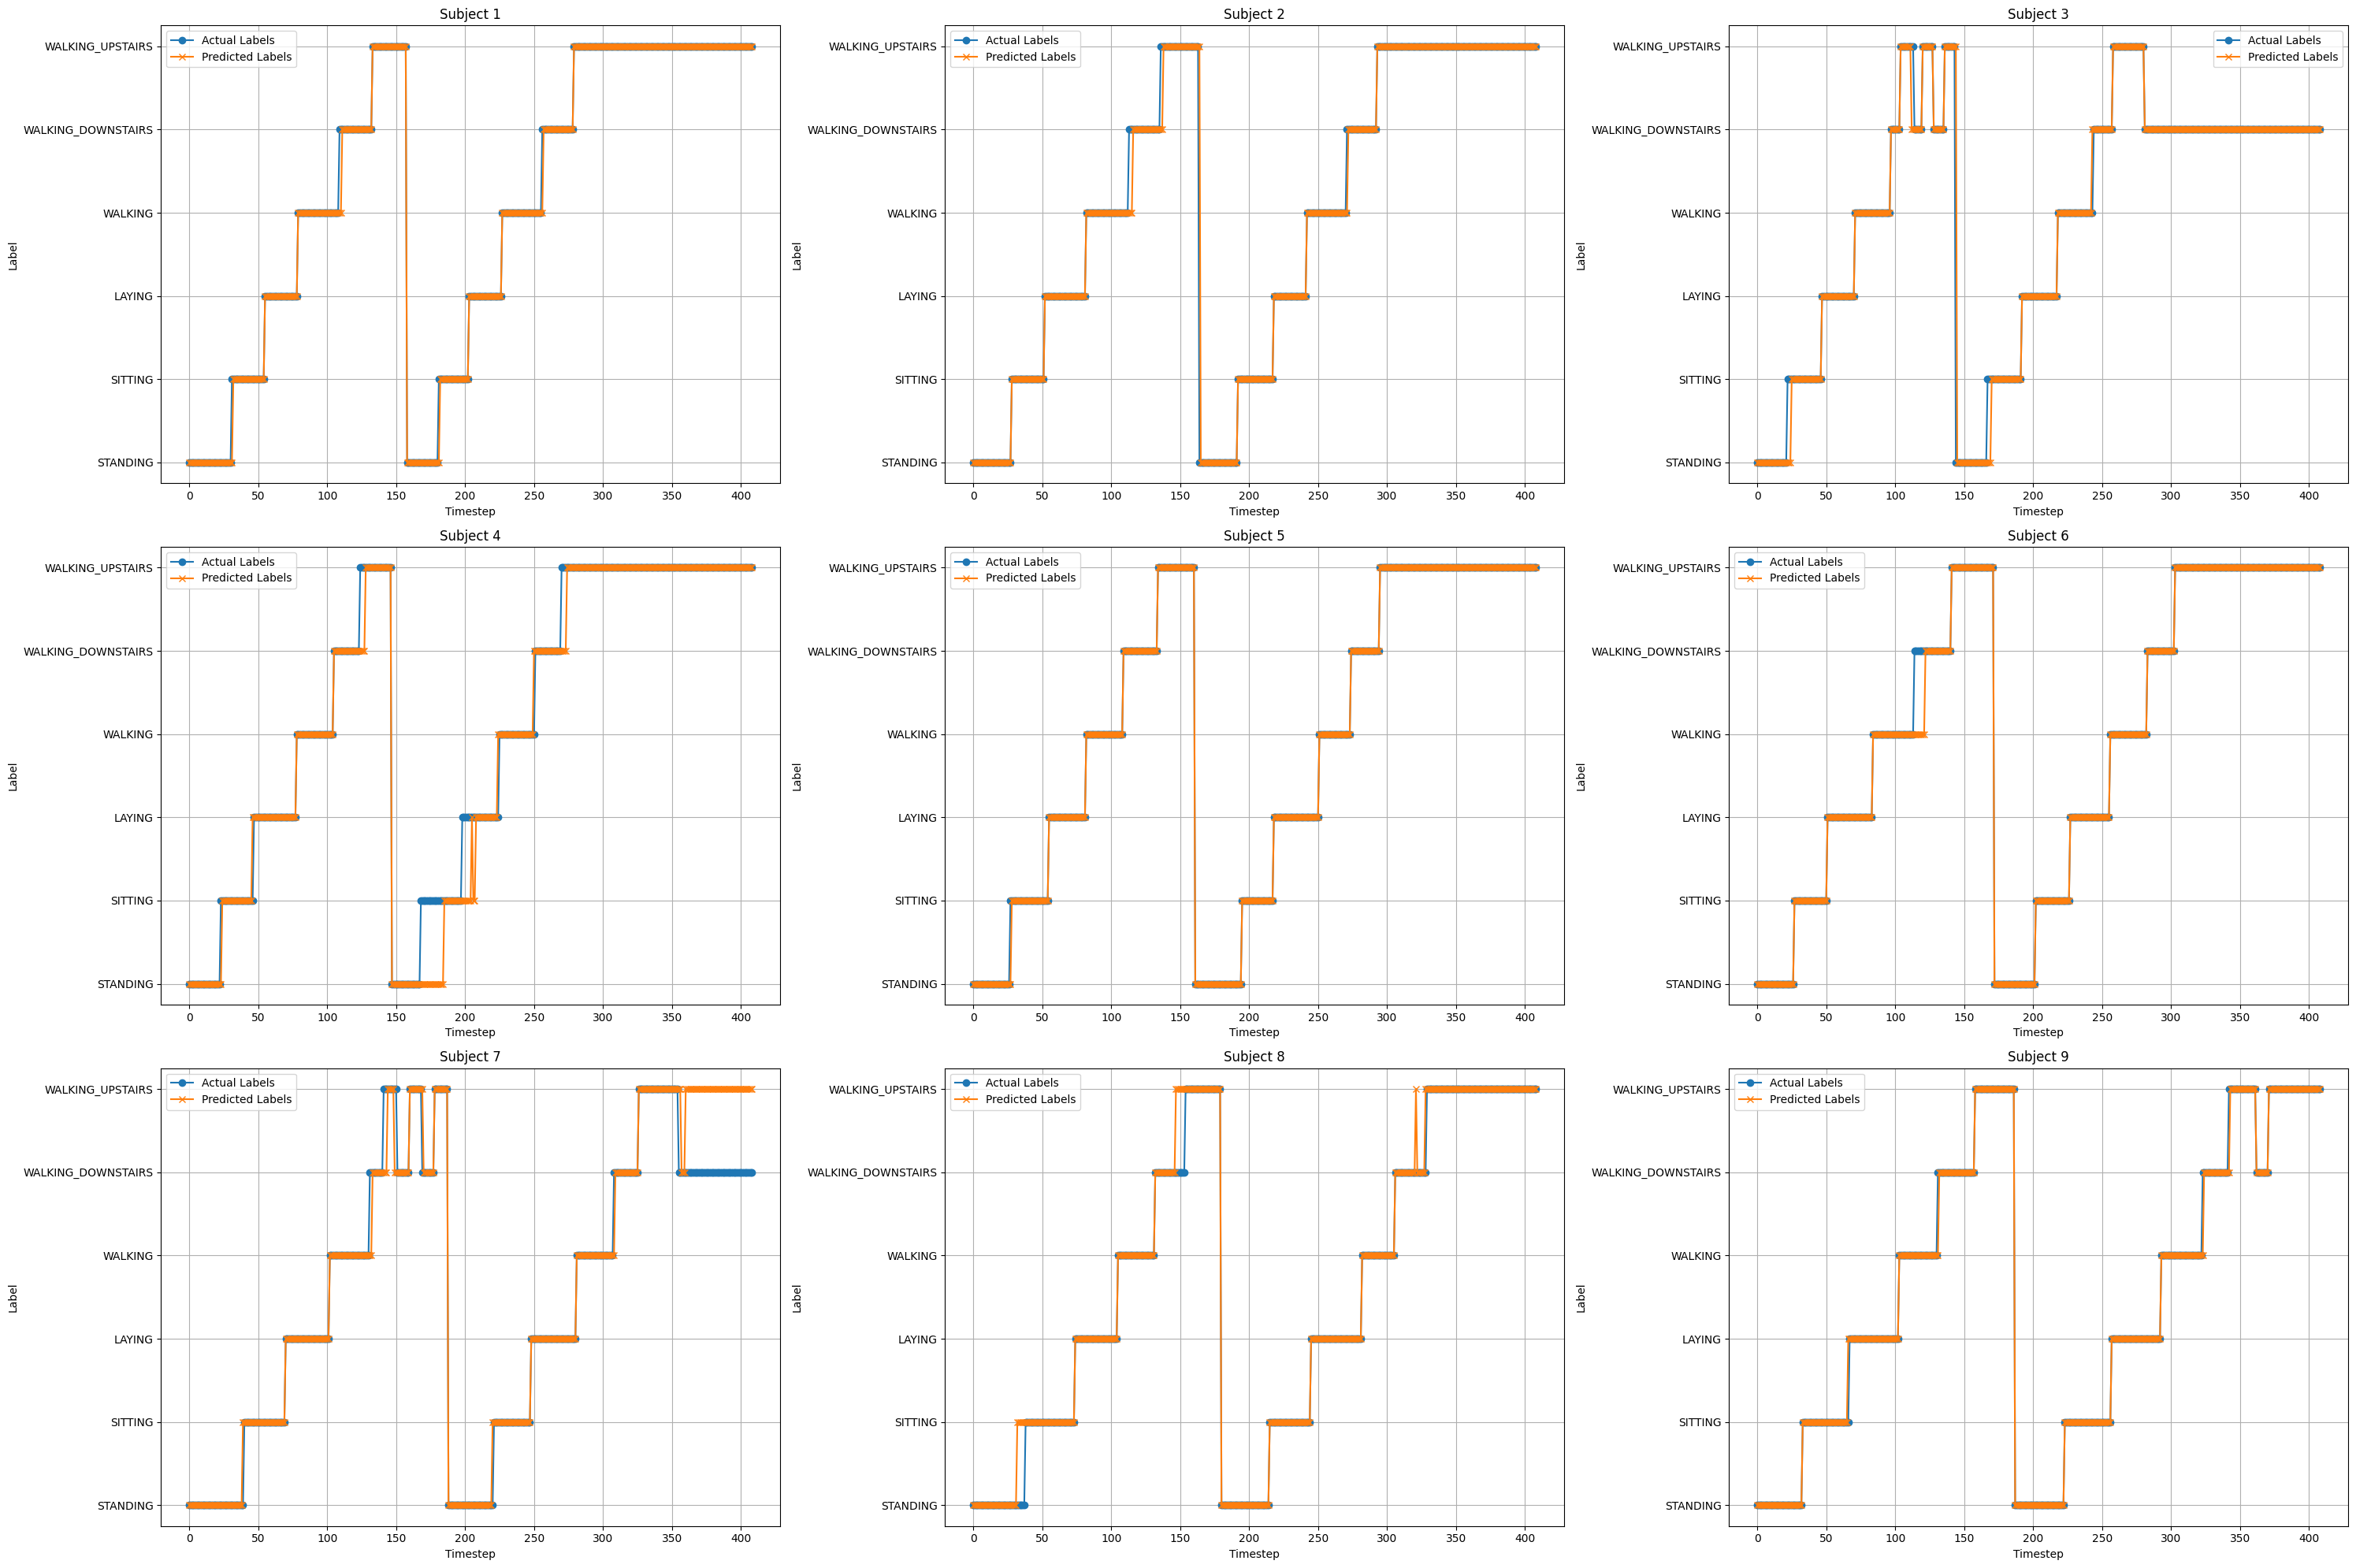

In [ ]:
import matplotlib.pyplot as plt

# Create a 7x3 grid for plotting all 21 subjects
fig, axes = plt.subplots(3, 3, figsize=(30, 20))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i in range(9):
    # Get the features, actual labels, and predicted labels for the subject
    subject_actual_labels = label_encoder.inverse_transform(y_test_encoded[i])
    subject_predicted_labels = label_encoder.inverse_transform(predicted_labels[i])

    # Plot the actual labels
    axes[i].plot(subject_actual_labels, label='Actual Labels', marker='o')

    # Plot the predicted labels
    axes[i].plot(subject_predicted_labels, label='Predicted Labels', marker='x')

    # Set title and labels
    axes[i].set_title(f'Subject {i + 1}')
    axes[i].set_xlabel('Timestep')
    axes[i].set_ylabel('Label')
    axes[i].legend()
    axes[i].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()



Vemos que el mayor error es en distinguir cuando un sujeto cambia de acción, además con el sujeto 7 cuando baja las escaleras y lo clasifica como subiendo. Además de eso, resulta muy buena predicción.